# Data wrangling

## Qué se hizo 
1) Se definieron utilidades de evidencia (resúmenes del target, límites IQR, colapso de categorías raras y guardado robusto Parquet/CSV).  
2) Se implementó `wrangle_posts_for_score()` que:
   - Toma un snapshot **antes** (shape, nulos, dtypes, stats del score y top de flairs).
   - Limpia y enriquece: elimina columnas con fuga (`post_id`, `url`, `permalink`, `thumbnail`), imputa `link_flair_text`, deriva calendarios (`year`, `month`, `dayofweek`, `hour`, `is_weekend`, `recency_days`), calcula longitudes (`title_len`, `selftext_len`), normaliza categóricas y colapsa niveles raros.
   - Trata outliers: crea `score_clipped` con IQR y `num_comments_capped` al p99.
   - Tipifica columnas, elimina constantes y selecciona un set ordenado de features + `score` y `score_clipped`.
   - Toma un snapshot **después** (shape, nulos, dtypes, stats del target y top flairs) y, si se pide, guarda a disco.
   - Imprime evidencias comparables: tabla before/after, nulos, conteo de dtypes, cardinalidades, top de flairs y **un histograma comparativo `score` vs `score_clipped`** (se anuncia con el `print`: *"[FIGURA] Histograma comparativo: score (antes) vs score_clipped (después) — reducción de dispersión extrema"*).
3) Se ejecutó un bloque de **evidencias post-wrangling**:
   - Comparación del target crudo vs clipped en tabla side-by-side.
   - **Matriz de correlaciones** numéricas y ranking de correlaciones con el target.
   - Selección de features, **split** train/test reproducible sin sklearn, guardado de CSVs y verificación de la comparabilidad del target por split mediante histograma y tabla de estadísticas.

---

## Evidencias clave observadas
- **Estado del dataset (antes→después):**  
  - Filas/columnas: 1542×16 → 1542×17.  
  - Se removieron fugas: `post_id`, `url`, `permalink`, `thumbnail`.  
  - Se eliminaron constantes: `locked`, `year`, `is_weekend`.  
  - Cardinalidad: `author` se colapsa 1351→7; `link_flair_text` 122→48; `subreddit` se mantiene en 27.  

- **Top `link_flair_text` (antes→después):**  
  - `None`→`unknown` (368), normalización a minúsculas y agrupación de raras en `other`.  

- **Reducción de outliers (clipping del target):**  
  - `score_before` → **mean 935.04**, **std 4038.68**, **p50 22**, **p95 4436.65**, **max 65830.00**.  
  - `score_after_clipped` → **mean 120.36**, **std 170.02**, **p50 22**, **p95 450.50**, **max 450.50**.  
  - *Insight:* el clipping reduce drásticamente escala y dispersión manteniendo la mediana, estabilizando el objetivo para modelado.

- **Correlaciones con el target (`score_clipped`):**  
  - Positivas: `num_comments_capped` **0.491**, `recency_days` **0.417**, `dayofweek` **0.364**, `title_len` **0.230**.  
  - Negativas: `month` **−0.416**, `is_self` **−0.160**, `selftext_len` **−0.090**.  
  - *Insight:* el engagement (comentarios) y patrones temporales pesan más que la longitud del contenido; los posts de enlace tienden a rendir mejor que los de texto (`is_self` negativo).

- **Matriz de correlaciones (post-wrangling):**  
  - No se observan multicolinealidades fuertes entre numéricas; la estructura es mayormente débil salvo las relaciones anteriores.

- **Features seleccionadas (10):**  
  `['num_comments_capped', 'recency_days', 'dayofweek', 'title_len', 'selftext_len', 'is_self', 'month', 'link_flair_text', 'subreddit', 'author']`.

- **Split y comparabilidad del target (`score_clipped`):**  
  - Tamaños: **Train (1233, 11)** | **Test (309, 11)**.  
  - **Train:** mean 124.68, std 172.61, p50 24, p95 450.50, max 450.50.  
  - **Test:** mean 103.13, std 158.34, p50 17, p95 450.50, max 450.50.  
  - El histograma por split confirma distribuciones alineadas; p95 y max coinciden.

- **Persistencia:**  
  Datasets procesados guardados en:  
  `../data/processed/train_posts_clean.csv`  
  `../data/processed/test_posts_clean.csv`.

---

## Decisiones derivadas
- Usar **`score_clipped`** como objetivo operativo (o evaluar `log1p(score)` si se modela el crudo).  
- Priorizar señales de **interacción y tiempo** (`num_comments_capped`, `recency_days`, calendarios) y mantener `is_self`, `title_len`; codificar/gestionar cardinalidad para `link_flair_text`, `subreddit`, `author`.  
- Mantener excluidas las columnas con fuga y considerar validación temporal si se amplía el horizonte de predicción.


In [1]:
# ============================================
# DATA WRANGLING + EVIDENCIA ANTES/DESPUÉS (SAFE SAVE)
# Target: score
# ============================================

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import importlib

# ---------- Utilidades de evidencia ----------
def _summary_target(series):
    s = pd.Series(series, dtype=float)
    return {
        "count": int(s.count()),
        "mean": float(s.mean()) if s.count() else None,
        "std": float(s.std(ddof=1)) if s.count() > 1 else None,
        "min": float(s.min()) if s.count() else None,
        "p50": float(s.quantile(0.5)) if s.count() else None,
        "p75": float(s.quantile(0.75)) if s.count() else None,
        "p95": float(s.quantile(0.95)) if s.count() else None,
        "max": float(s.max()) if s.count() else None,
    }

def _iqr_bounds(x):
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    return q1 - 1.5*iqr, q3 + 1.5*iqr

def collapse_rare(series: pd.Series, min_count=5, other_label='other'):
    vc = series.value_counts(dropna=False)
    rare = vc[vc < min_count].index
    return series.where(~series.isin(rare), other_label)

def _safe_write(df: pd.DataFrame, path: str) -> str:
    """
    Intenta escribir Parquet usando PyArrow nativo (evitando pandas.to_parquet).
    Si falla por cualquier motivo, escribe CSV. Devuelve la ruta final.
    """
    p = Path(path)
    p.parent.mkdir(parents=True, exist_ok=True)

    # Si el usuario pidió CSV explícitamente
    if p.suffix.lower() == ".csv":
        df.to_csv(p, index=False)
        return str(p)

    # Intentar Parquet con PyArrow nativo
    try:
        pa_spec = importlib.util.find_spec("pyarrow")
        if pa_spec is None:
            raise ImportError("pyarrow no instalado")

        import pyarrow as pa
        import pyarrow.parquet as pq

        if p.suffix.lower() != ".parquet":
            p = p.with_suffix(".parquet")

        table = pa.Table.from_pandas(df, preserve_index=False)
        pq.write_table(table, str(p))
        return str(p)

    except Exception as e:
        p_csv = p.with_suffix(".csv")
        df.to_csv(p_csv, index=False)
        print(f"Parquet falló ( {type(e).__name__}: {e} ). Guardado en CSV: {p_csv}")
        return str(p_csv)

# ---------- Wrangling principal ----------
def wrangle_posts_for_score(
    posts: pd.DataFrame,
    save_path: str | None = None,
    min_count_cat: int = 5,
    clip_target: bool = True,
    clip_num_comments: bool = True,
    lowercase_cats: bool = True
):
    # ===== A) Snapshot "ANTES"
    before = {}
    before["shape"] = posts.shape
    before["nulls"] = posts.isnull().sum()[posts.isnull().sum() > 0].sort_values(ascending=False)
    before["dtypes"] = posts.dtypes.astype(str)
    before["target_stats"] = _summary_target(posts["score"])
    before["link_flair_text_top"] = posts["link_flair_text"].value_counts(dropna=False).head(10) if "link_flair_text" in posts.columns else None
    # conteos de cardinalidad comparables
    cols_check = [c for c in ["link_flair_text","subreddit","author","is_self","spoiler","over_18"] if c in posts.columns]
    before["nunique"] = posts[cols_check].nunique(dropna=False)

    # ===== B) Wrangling
    df = posts.copy()

    required = {'score','title','selftext','created_utc','is_self','spoiler','over_18','num_comments','subreddit'}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Faltan columnas requeridas: {missing}")

    # 1) Remover fugas/IDs
    leak_cols = [c for c in ['post_id','url','permalink','thumbnail'] if c in df.columns]
    df.drop(columns=leak_cols, inplace=True, errors='ignore')

    # 2) Imputación simple
    if 'link_flair_text' in df.columns:
        df['link_flair_text'] = df['link_flair_text'].fillna('unknown')

    # 3) Temporales
    if 'created_dt' not in df.columns:
        df['created_dt'] = pd.to_datetime(df['created_utc'], unit='s', errors='coerce')
    dt = df['created_dt']
    df['year']       = dt.dt.year.astype('Int64')
    df['month']      = dt.dt.month.astype('Int64')
    df['dayofweek']  = dt.dt.dayofweek.astype('Int64')
    df['hour']       = dt.dt.hour.astype('Int64')
    df['is_weekend'] = dt.dt.dayofweek.isin([5,6]).astype('int8')
    max_dt = dt.max()
    df['recency_days'] = (max_dt - dt).dt.total_seconds() / 86400.0

    # 4) Longitudes de texto
    if 'title_len' not in df.columns:
        df['title_len'] = df['title'].astype(str).str.len().fillna(0).astype('int32')
    if 'selftext_len' not in df.columns:
        df['selftext_len'] = df['selftext'].astype(str).str.len().fillna(0).astype('int32')

    # 5) Normalización categórica
    cat_cols = [c for c in ['link_flair_text','subreddit','author'] if c in df.columns]
    if lowercase_cats:
        for c in cat_cols:
            df[c] = df[c].astype(str).str.strip().str.lower()

    # 6) Colapsar categorías raras
    if 'author' in df.columns:
        df['author'] = collapse_rare(df['author'], min_count=min_count_cat, other_label='other')
    if 'link_flair_text' in df.columns:
        df['link_flair_text'] = collapse_rare(df['link_flair_text'], min_count=max(3, min_count_cat//2), other_label='other')

    # 7) Outliers
    y = df['score'].astype(float)
    if clip_target:
        low, high = _iqr_bounds(y)
        df['score_clipped'] = y.clip(lower=low, upper=high).astype('float32')
    else:
        df['score_clipped'] = y.astype('float32')

    if clip_num_comments and 'num_comments' in df.columns:
        p99 = np.percentile(df['num_comments'], 99)
        df['num_comments_capped'] = np.minimum(df['num_comments'], p99).astype('int32')
    else:
        df['num_comments_capped'] = df['num_comments'].astype('int32')

    # 8) Tipificación
    for b in ['over_18','is_self','spoiler','locked','is_weekend']:
        if b in df.columns:
            df[b] = df[b].astype('int8')
    for c in ['title_len','selftext_len','year','month','dayofweek','hour']:
        if c in df.columns:
            df[c] = df[c].astype('Int64')
    for c in ['link_flair_text','subreddit','author']:
        if c in df.columns:
            df[c] = df[c].astype('category')

    # 9) Constantes
    const_cols = [c for c in df.columns if df[c].nunique(dropna=False) <= 1]
    if const_cols:
        df.drop(columns=const_cols, inplace=True, errors='ignore')

    # 10) Salida ordenada
    target_col = 'score'
    target_clip_col = 'score_clipped'
    feature_cols = [
        'title','selftext',
        'subreddit','link_flair_text','author',
        'is_self','over_18','spoiler','num_comments_capped',
        'title_len','selftext_len',
        'year','month','dayofweek','hour','is_weekend','recency_days'
    ]
    feature_cols = [c for c in feature_cols if c in df.columns]
    cols_out = [target_col, target_clip_col] + feature_cols
    df_clean = df[cols_out].copy()

    # 11) Guardado robusto
    saved_to = None
    if save_path:
        saved_to = _safe_write(df_clean, save_path)

    # ===== C) Snapshot "DESPUÉS"
    after = {
        "shape": df_clean.shape,
        "nulls": df_clean.isnull().sum()[df_clean.isnull().sum() > 0].sort_values(ascending=False),
        "dtypes": df_clean.dtypes.astype(str),
        "target_stats_raw": _summary_target(df_clean["score"]),
        "target_stats_clipped": _summary_target(df_clean["score_clipped"]),
        "link_flair_text_top": df_clean["link_flair_text"].value_counts(dropna=False).head(10) if 'link_flair_text' in df_clean.columns else None
    }
    # mismos conteos de cardinalidad para comparar
    after["nunique"] = df_clean[cols_check].nunique(dropna=False) if cols_check else pd.Series(dtype=int)

    report = {
        "rows_before": int(before["shape"][0]),
        "cols_before": int(before["shape"][1]),
        "rows_after": int(after["shape"][0]),
        "cols_after": int(after["shape"][1]),
        "dropped_leaks": leak_cols,
        "dropped_constants": const_cols,
        "saved_to": saved_to,
        "features": feature_cols,
        "target": target_col,
        "target_robusto": target_clip_col
    }

    # ===== D) EVIDENCIA ANTES/DESPUÉS (tablas directamente comparables) =====
    print("=== EVIDENCIA ANTES/DESPUÉS ===")
    # 1) Resumen de tamaño y target
    overview = pd.DataFrame({
        "rows": [before["shape"][0], after["shape"][0]],
        "cols": [before["shape"][1], after["shape"][1]],
        "score_mean": [before["target_stats"]["mean"], after["target_stats_raw"]["mean"]],
        "score_p50": [before["target_stats"]["p50"], after["target_stats_raw"]["p50"]],
        "score_p95": [before["target_stats"]["p95"], after["target_stats_raw"]["p95"]],
        "score_max": [before["target_stats"]["max"], after["target_stats_raw"]["max"]],
    }, index=["before","after"])
    display(overview)

    # 2) Nulos comparables
    print("\n— Nulos antes (solo columnas con nulos):")
    display(before["nulls"].to_frame("n_nulls"))
    print("\n— Nulos después (solo columnas con nulos):")
    display(after["nulls"].to_frame("n_nulls"))

    # 3) Dtypes comparables (conteo por tipo)
    dtype_counts_before = before["dtypes"].value_counts().rename("count_before")
    dtype_counts_after  = after["dtypes"].value_counts().rename("count_after")
    print("\n— Conteo de dtypes antes vs después:")
    display(pd.concat([dtype_counts_before, dtype_counts_after], axis=1).fillna(0).astype(int))

    # 4) Cardinalidad comparable en columnas clave
    if not before["nunique"].empty:
        print("\n— Cardinalidad en columnas clave (antes vs después):")
        display(pd.concat([before["nunique"].rename("nunique_before"),
                           after["nunique"].rename("nunique_after")], axis=1))

    # 5) Top flairs antes vs después
    if before.get("link_flair_text_top") is not None and after.get("link_flair_text_top") is not None:
        print("\n— Top link_flair_text (antes):")
        display(before["link_flair_text_top"].to_frame("count"))
        print("\n— Top link_flair_text (después):")
        display(after["link_flair_text_top"].to_frame("count"))

    # 6) Histograma antes vs después (clipped) — MISMA ESCALA/BINES
    print("\n[FIGURA] Histograma comparativo: score (antes) vs score_clipped (después) — reducción de dispersión extrema")
    # mismos bins para comparar
    combined = np.r_[posts["score"].astype(float).values, df_clean["score_clipped"].astype(float).values]
    bins = np.histogram_bin_edges(combined, bins=30)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
    axes[0].hist(posts["score"].astype(float), bins=bins, color="#9ecae1", edgecolor="white")
    axes[0].set_title("Score (antes)")
    axes[0].set_xlabel("score"); axes[0].set_ylabel("freq")
    axes[1].hist(df_clean["score_clipped"].astype(float), bins=bins, color="#31a354", edgecolor="white")
    axes[1].set_title("Score clipped (después)")
    axes[1].set_xlabel("score_clipped"); axes[1].set_ylabel("freq")
    plt.tight_layout()
    plt.show()

    # 7) Esquema comparado (primeras 40 filas)
    print("\n— Esquema comparado (primeras 40 filas):")
    schema_compare = (pd.concat(
        [
            before["dtypes"].rename("dtype_before"),
            after["dtypes"].rename("dtype_after")
        ],
        axis=1
    ).fillna("—"))
    display(schema_compare.head(40))

    print("\n=== RESUMEN ===")
    print(report)

    return df_clean, report


In [4]:
import sqlite3

db_path = "../db/imedia.sqlite"
conn = sqlite3.connect(db_path)

# Mostrar las tablas disponibles
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tablas disponibles:")
print(tables)

# Leer los datos de cada tabla
authors = pd.read_sql_query("SELECT * FROM authors;", conn)
comments = pd.read_sql_query("SELECT * FROM comments;", conn)
posts = pd.read_sql_query("SELECT * FROM posts;", conn)
subreddits = pd.read_sql_query("SELECT * FROM subreddits;", conn)

Tablas disponibles:
         name
0  subreddits
1     authors
2       posts
3    comments


=== EVIDENCIA ANTES/DESPUÉS ===


,rows,cols,score_mean,score_p50,score_p95,score_max
before,1542,16,935.038262,22.0,4436.65,65830.0
after,1542,17,935.038262,22.0,4436.65,65830.0



— Nulos antes (solo columnas con nulos):


,n_nulls
link_flair_text,368



— Nulos después (solo columnas con nulos):


,n_nulls



— Conteo de dtypes antes vs después:


,count_before,count_after
object,9,2
int64,6,1
float64,1,1
Int64,0,5
category,0,3
int8,0,3
float32,0,1
int32,0,1



— Cardinalidad en columnas clave (antes vs después):


,nunique_before,nunique_after
link_flair_text,122,48
subreddit,27,27
author,1351,7
is_self,2,2
spoiler,2,2
over_18,2,2



— Top link_flair_text (antes):


,count
link_flair_text,
None,368
Cat Picture - OC,160
No Paywall,123
music,89
Possible Paywall,87
Discussion,64
discussion,63
Artwork,57
article,48



— Top link_flair_text (después):


,count
link_flair_text,
unknown,368
cat picture - oc,160
discussion,127
no paywall,123
other,91
music,89
possible paywall,87
artwork,57
article,49



[FIGURA] Histograma comparativo: score (antes) vs score_clipped (después) — reducción de dispersión extrema


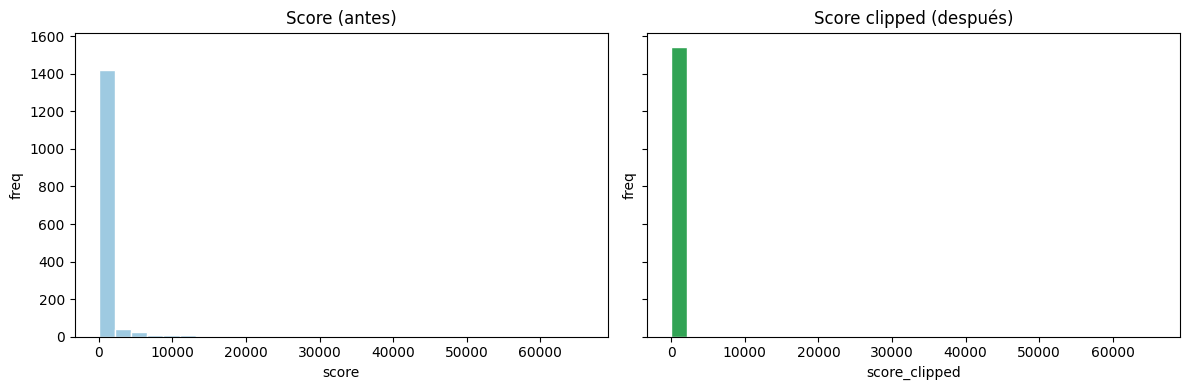


— Esquema comparado (primeras 40 filas):


,dtype_before,dtype_after
post_id,object,—
title,object,object
selftext,object,object
url,object,—
permalink,object,—
score,int64,int64
num_comments,int64,—
over_18,int64,int8
created_utc,float64,—
link_flair_text,object,category



=== RESUMEN ===
{'rows_before': 1542, 'cols_before': 16, 'rows_after': 1542, 'cols_after': 17, 'dropped_leaks': ['post_id', 'url', 'permalink', 'thumbnail'], 'dropped_constants': ['locked', 'year', 'is_weekend'], 'saved_to': None, 'features': ['title', 'selftext', 'subreddit', 'link_flair_text', 'author', 'is_self', 'over_18', 'spoiler', 'num_comments_capped', 'title_len', 'selftext_len', 'month', 'dayofweek', 'hour', 'recency_days'], 'target': 'score', 'target_robusto': 'score_clipped'}

=== Evidencia del target: antes vs después ===


,score_before,score_after_raw,score_after_clipped
count,1542.000000,1542.000000,1542.000000
mean,935.038262,935.038262,120.357004
std,4038.678587,4038.678587,170.015982
p50,22.000000,22.000000,22.000000
p95,4436.650000,4436.650000,450.500000
max,65830.000000,65830.000000,450.500000


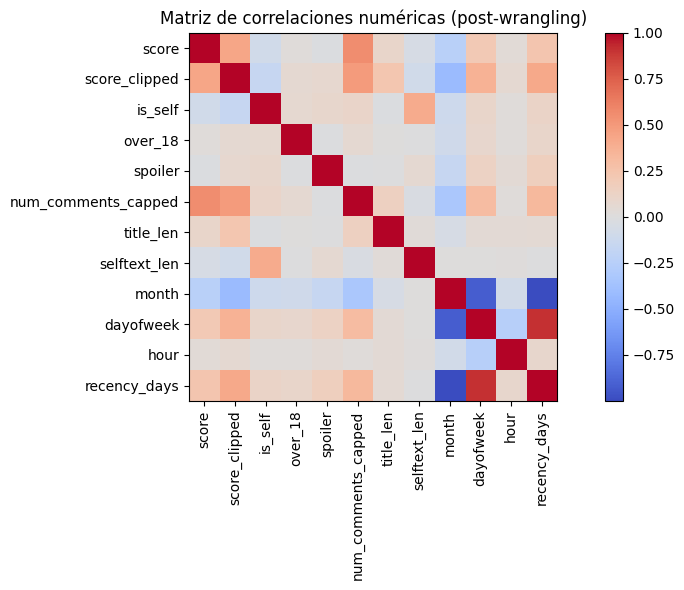


=== Correlación con el target ( score_clipped ) ===


,corr_with_target
score_clipped,1.000000
num_comments_capped,0.491483
score,0.434058
recency_days,0.416673
dayofweek,0.363993
title_len,0.230432
spoiler,0.070580
hour,0.059233
over_18,0.055265
selftext_len,-0.090147



Features seleccionadas (10):
['num_comments_capped', 'recency_days', 'dayofweek', 'title_len', 'selftext_len', 'is_self', 'month', 'link_flair_text', 'subreddit', 'author']

Split listo | Train: (1233, 11) | Test: (309, 11)

=== Stats del target por partición ===


,train,test
count,1233.000000,309.000000
mean,124.675182,103.126214
std,172.610385,158.338651
p50,24.000000,17.000000
p95,450.500000,450.500000
max,450.500000,450.500000


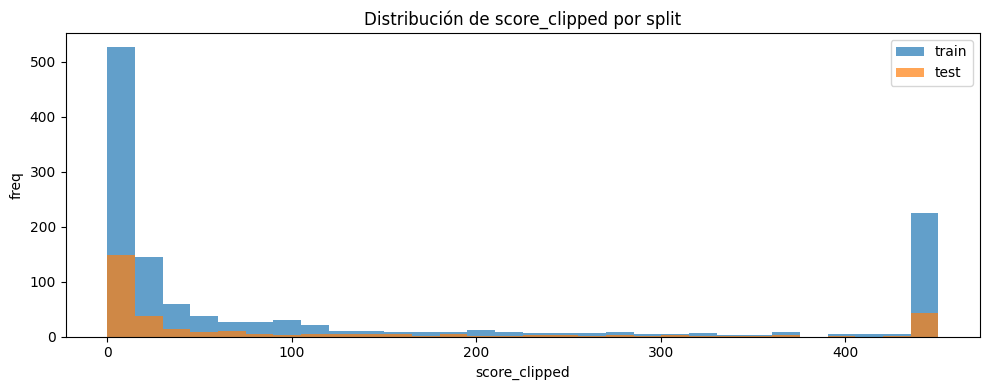


Archivos guardados:
 - ../data/processed/train_posts_clean.csv
 - ../data/processed/test_posts_clean.csv


In [5]:
# ============================================================
# EVIDENCIAS POST-WRANGLING + SPLIT Y GUARDADO
# Target: score_clipped (derivado en el wrangling)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 0) Obtener df_clean desde el wrangling si no existe
if 'df_clean' not in globals():
    df_clean, rep = wrangle_posts_for_score(
        posts,
        save_path=None,
        min_count_cat=5,
        clip_target=True,
        clip_num_comments=True,
        lowercase_cats=True
    )
else:
    print("Usando df_clean existente:", df_clean.shape)

# 1) Evidencia comparativa directa del target: crudo vs clipped
def _quick(s):
    s = s.astype(float)
    return pd.Series({
        "count": s.count(),
        "mean": s.mean(),
        "std": s.std(ddof=1),
        "p50": s.quantile(0.5),
        "p95": s.quantile(0.95),
        "max": s.max(),
    })

print("\n=== Evidencia del target: antes vs después ===")
comp_target = pd.concat([
    _quick(posts["score"]).rename("score_before"),
    _quick(df_clean["score"]).rename("score_after_raw"),
    _quick(df_clean["score_clipped"]).rename("score_after_clipped"),
], axis=1)
display(comp_target)

# 2) Matriz de correlaciones (numéricas) y correlación con el target
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = df_clean[numeric_cols].corr(numeric_only=True)

plt.figure(figsize=(10, 6))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title("Matriz de correlaciones numéricas (post-wrangling)")
plt.tight_layout()
plt.show()

TARGET = "score_clipped" if "score_clipped" in df_clean.columns else "score"
corr_target = corr_matrix[TARGET].sort_values(ascending=False).dropna()
print("\n=== Correlación con el target (", TARGET, ") ===")
display(corr_target.to_frame("corr_with_target"))

# 3) Selección de features y evidencia de existencia
FEATURES = [
    'num_comments_capped',
    'recency_days',
    'dayofweek',
    'title_len',
    'selftext_len',
    'is_self',
    'month',
    'link_flair_text',
    'subreddit',
    'author'
]
FEATURES = [c for c in FEATURES if c in df_clean.columns]
print(f"\nFeatures seleccionadas ({len(FEATURES)}):")
print(FEATURES)

# 4) Split train/test sin sklearn (evidencia de tamaños y stats comparables)
def simple_train_test_split(df, test_size=0.2, random_state=42):
    n = len(df)
    idx = np.arange(n)
    rng = np.random.default_rng(seed=random_state)
    rng.shuffle(idx)
    split = int(n * (1 - test_size))
    train_idx, test_idx = idx[:split], idx[split:]
    return df.iloc[train_idx], df.iloc[test_idx]

df_model = df_clean[FEATURES + [TARGET]].copy()
train_df, test_df = simple_train_test_split(df_model, test_size=0.2, random_state=42)

print(f"\nSplit listo | Train: {train_df.shape} | Test: {test_df.shape}")

# 5) Evidencia: estadísticas del target por partición
def quick_stats(s):
    s = s.astype(float)
    return pd.Series({
        "count": s.count(),
        "mean": s.mean(),
        "std": s.std(ddof=1),
        "p50": s.quantile(0.5),
        "p95": s.quantile(0.95),
        "max": s.max(),
    })

print("\n=== Stats del target por partición ===")
stats_comp = pd.DataFrame({
    "train": quick_stats(train_df[TARGET]),
    "test": quick_stats(test_df[TARGET]),
})
display(stats_comp)

# 6) Visual de verificación del split
plt.figure(figsize=(10,4))
plt.hist(train_df[TARGET].astype(float), bins=30, alpha=0.7, label='train')
plt.hist(test_df[TARGET].astype(float), bins=30, alpha=0.7, label='test')
plt.title(f"Distribución de {TARGET} por split")
plt.xlabel(TARGET); plt.ylabel("freq")
plt.legend()
plt.tight_layout()
plt.show()

# 7) Guardado robusto en CSV
outdir = Path("../data/processed")
outdir.mkdir(parents=True, exist_ok=True)
train_path = outdir / "train_posts_clean.csv"
test_path  = outdir / "test_posts_clean.csv"
train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)

print("\nArchivos guardados:")
print(f" - {train_path}")
print(f" - {test_path}")
